<a href="https://colab.research.google.com/github/galudSla/spam-not-spam/blob/main/spam_or_not_spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC


In [26]:
url = 'https://raw.githubusercontent.com/galudSla/spam-not-spam/main/spam_or_not_spam.csv'
df = pd.read_csv(url)

In [27]:
df.info
df.shape
df.isnull().sum()
print("Count of label:\n",df['label'].value_counts())

Count of label:
 0    1000
1     500
Name: label, dtype: int64


In [28]:
df.dropna(inplace = True)
df.reset_index(drop=True, inplace=True)
df.isnull().sum()
print("Count of label:\n",df['label'].value_counts())
print("Not a Spam:",round(len(df[df['label']==0])/len(df['label']),2)*100,"%")
print("Spam Email:",round(len(df[df['label']==1])/len(df['label']),2)*100,"%")


Count of label:
 0    1000
1     499
Name: label, dtype: int64
Not a Spam: 67.0 %
Spam Email: 33.0 %


Regex cleaning

In [ ]:
#Lower case all words
df['email'] = df['email'].str.lower()

#Creating the new column for length of email column
df['length'] = df.email.str.len()

# Replace email addresses with 'email'
df['email'] = df['email'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

# Replace URLs with 'webaddress'
df['email'] = df['email'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

# Replace currency symbols with 'moneysymb'
df['email'] = df['email'].str.replace(r'£|\$', 'dollers')

# Replace 10 digit phone numbers with 'phonenumber'
df['email'] = df['email'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')

# Replace numeric characters with 'numbr'
df['email'] = df['email'].str.replace(r'\d+(\.\d+)?', 'numbr')

# Remove punctuation
df['email'] = df['email'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
df['email'] = df['email'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df['email'] = df['email'].str.replace(r'^\s+|\s+?$', '')

#Removing the stopwords
stop_words = set(stopwords.words('english'))
df['email'] = df['email'].apply(lambda x: " ".join(term for term in x.split() if term not in stop_words))

# New column (clean_length) after puncuations,stopwords removal
df['clean_length'] = df.email.str.len()

Total length removal

In [30]:
print("Original Length:",df.length.sum())
print("Cleaned Length:",df.clean_length.sum())
print("Total Words Removed:",(df.length.sum()) - (df.clean_length.sum()))


Original Length: 1905256
Cleaned Length: 1464285
Total Words Removed: 440971


In [ ]:
#Graphical Visualisation for counting number of labels.
plt.figure(figsize=(6,4))
sns.countplot(df['label'],palette= 'Reds')
plt.title("Counting the number of labels",fontsize=15)
plt.xticks(rotation='horizontal')
print(df.label.value_counts())

Message distribution before cleaning

<ipython-input-32-1a8f9c735970>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['label']==1]['length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
<ipython-input-32-1a8f9c735970>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['label']==0]['length'],bins=20, ax=a

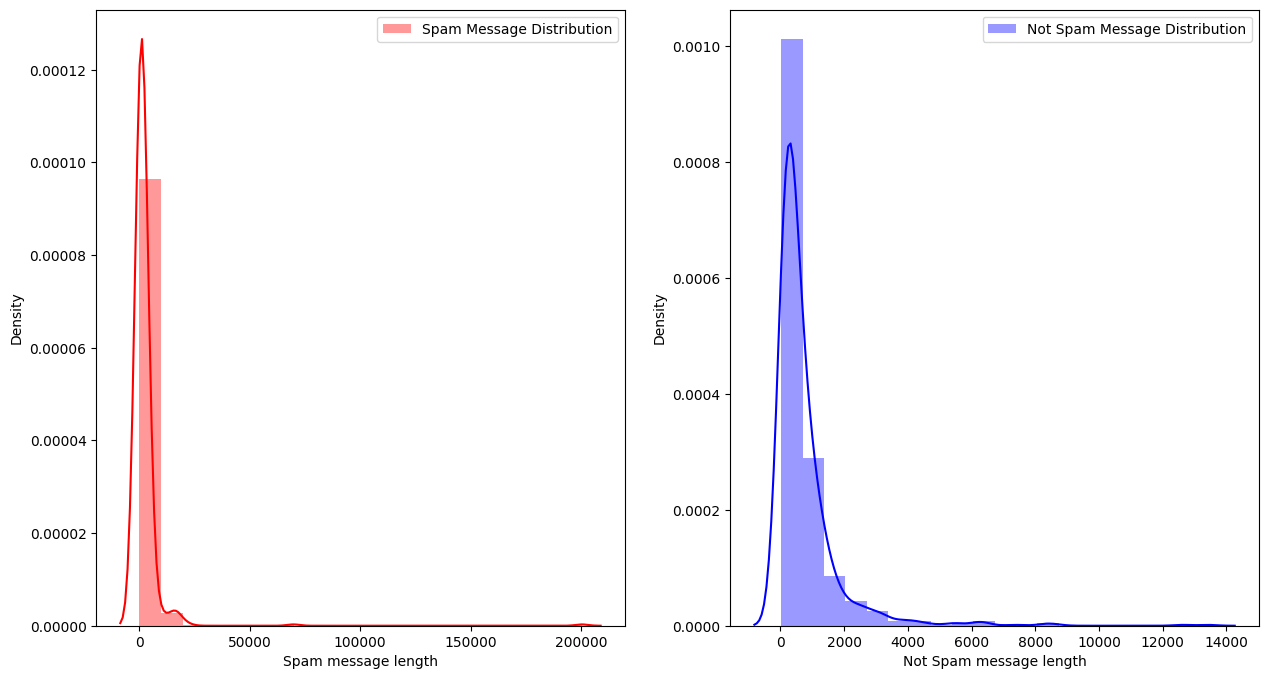

In [32]:
f,ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(df[df['label']==1]['length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()
sns.distplot(df[df['label']==0]['length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='b')
ax[1].set_xlabel('Not Spam message length')
ax[1].legend()

Message distribution after cleaning

<ipython-input-33-63ed59be61f4>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['label']==1]['clean_length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
<ipython-input-33-63ed59be61f4>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['label']==0]['clean_length'],b

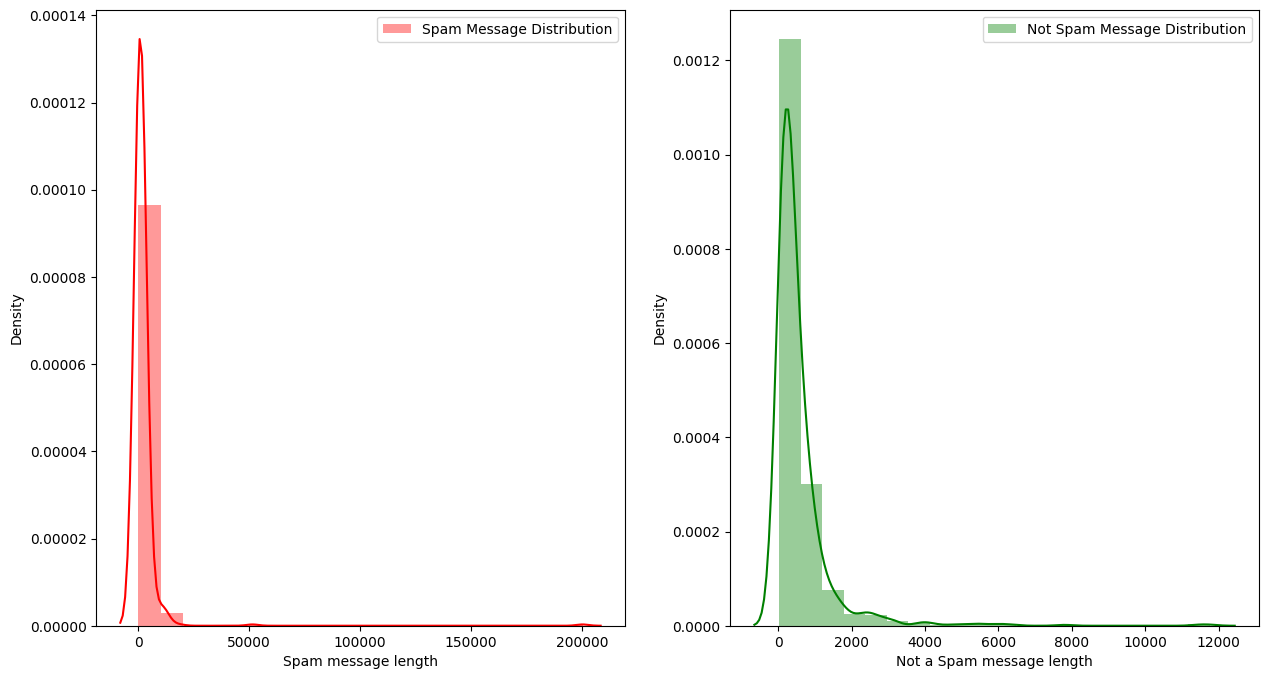

In [33]:
f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']==1]['clean_length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()
sns.distplot(df[df['label']==0]['clean_length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='g')
ax[1].set_xlabel('Not a Spam message length')
ax[1].legend()
plt.show()

Getting sense of loud words in not-spam

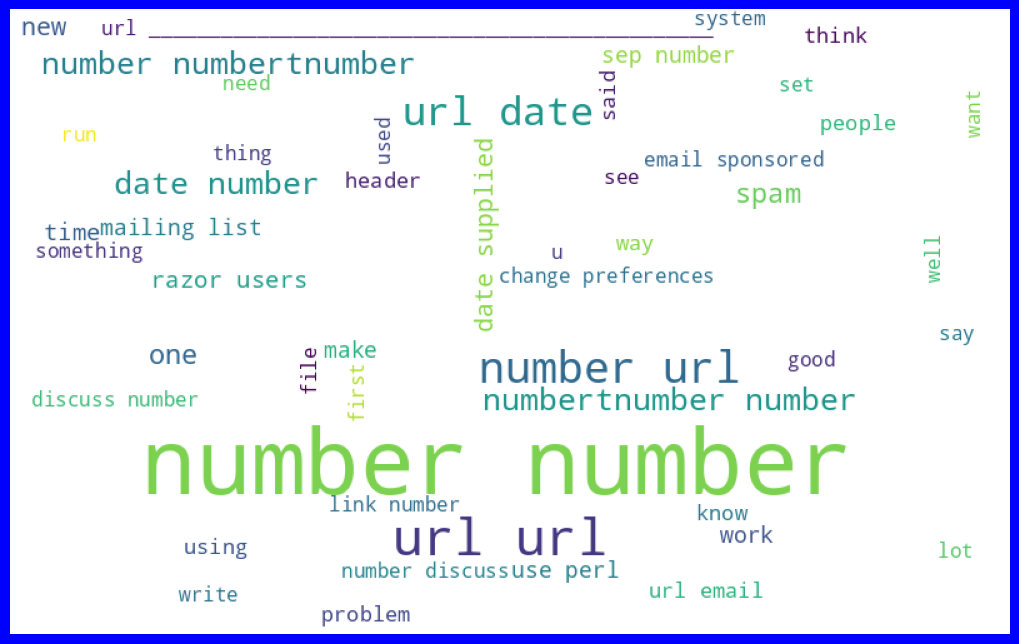

In [34]:
not_spams = df['email'][df['label']==0]
spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(not_spams))
plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

Getting sense of loud words in not-spam

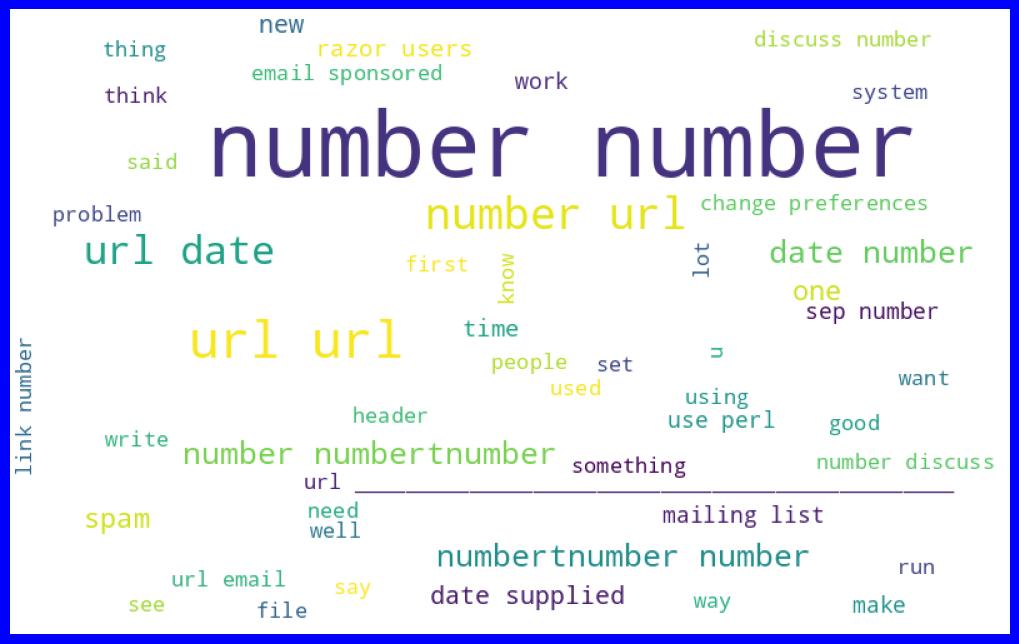

In [35]:
not_spams = df['email'][df['label']==0]
spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(not_spams))
plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Convert text into vectors using TF-IDF

In [36]:
tf_vec = TfidfVectorizer()
SVM = SVC(C=1.0, kernel='linear', degree=3 , gamma='auto')
features = tf_vec.fit_transform(df['email'])
X = features
y = df['label']

In [37]:
X_train,x_test,Y_train,y_test = train_test_split(X,y, random_state=42)
SVM.fit(X_train,Y_train)
y_pred = SVM.predict(x_test)
print ('Final score = > ', accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

Final score = >  0.9813333333333333
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       240
           1       1.00      0.95      0.97       135

    accuracy                           0.98       375
   macro avg       0.99      0.97      0.98       375
weighted avg       0.98      0.98      0.98       375



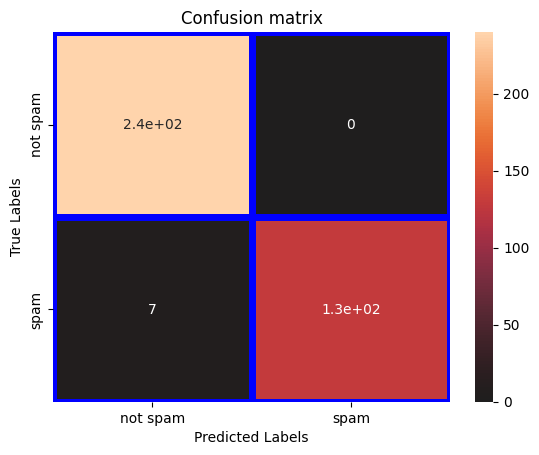

In [38]:
conf_mat = confusion_matrix(y_test,y_pred)
ax=plt.subplot()
sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='b',center=0)
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')
ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['not spam','spam'])
ax.yaxis.set_ticklabels(['not spam','spam'])
plt.show()